In [1]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@3485a81c3f2a-886440af91704af78f87712fa89369de: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@3485a81c3f2a-886440af91704af78f87712fa89369de: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
root@3485a81c3f2a-886440af91704af78f87712fa89369de: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@3485a81c3f2a-886440af91704af78f87712fa89369de: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 10689
root@3485a81c3f2a-886440af91704af78f87712fa89369de: cat /tmp/tmpuvo3s87v/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:10,opendir_timeout_ms:120000,virtual_folders_omit_spaces:true --inet_family=IPV4_ONLY --preferences

In [2]:
! cat /proc/meminfo

MemTotal:       26696424 kB
MemFree:        25265372 kB
MemAvailable:   25660824 kB
Buffers:           39568 kB
Cached:           626240 kB
SwapCached:            0 kB
Active:           673088 kB
Inactive:         470780 kB
Active(anon):     468844 kB
Inactive(anon):      488 kB
Active(file):     204244 kB
Inactive(file):   470292 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1732 kB
Writeback:             0 kB
AnonPages:        478600 kB
Mapped:           137740 kB
Shmem:              1284 kB
KReclaimable:      88280 kB
Slab:             160864 kB
SReclaimable:      88280 kB
SUnreclaim:        72584 kB
KernelStack:        6672 kB
PageTables:         7844 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13348212 kB
Committed_AS:    4124964 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       47500 kB
VmallocChunk:          0 kB
Percpu:          

In [3]:
import os
os.chdir('./drive/MyDrive/python_project/dacon_hand')

In [4]:
# ! unzip ./new_open.zip -d ./open

In [5]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# 파일경로 설정
import os
import shutil
import json

# Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model

# GPU 환경 설정
import os

import gc
from keras import backend as k

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [6]:
data_path = './open'

train_path = data_path + '/train'
test_path = data_path + '/test'
crop_train_path = data_path + '/crop_train2'
crop_test_path = data_path + '/crop_test2'

hand_gesture = pd.read_csv(data_path + '/hand_gesture_pose.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [7]:
# Train 데이터에 있는 폴더를 glob로 불러와
# sorted method를 통해 숫자 순으로 정렬합니다.
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
crop_train_folders = sorted(glob(crop_train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
crop_test_folders  = sorted(glob(crop_test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
train_folders[:5]

['./open/train/0',
 './open/train/1',
 './open/train/2',
 './open/train/3',
 './open/train/4']

In [8]:
train_folder = train_folders[0]
crop_train_folder = crop_train_folders[0]

image_paths = sorted(glob(crop_train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
json_path   = glob(train_folder + '/*.json')[0]

In [9]:
image_paths

['./open/crop_train2/0/0.png',
 './open/crop_train2/0/1.png',
 './open/crop_train2/0/2.png',
 './open/crop_train2/0/3.png',
 './open/crop_train2/0/4.png',
 './open/crop_train2/0/5.png',
 './open/crop_train2/0/6.png',
 './open/crop_train2/0/7.png',
 './open/crop_train2/0/8.png']

(692, 602, 3)


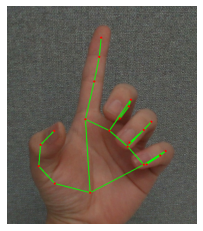

In [10]:
image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [11]:
js = json.load(open(json_path))

print("json keys              : ", js.keys())

print("json action info       : ",js.get('action'))

print("json actor info        : ",js.get('actor'))

print("json annotations keys  : ",js.get('annotations')[0].keys())

json keys              :  dict_keys(['action', 'actor', 'id', 'annotations'])
json action info       :  [0, '숫자 1']
json actor info        :  None
json annotations keys  :  dict_keys(['image_id', 'data'])


In [12]:
# answers = []
# for train_folder in train_folders :
#     json_path = glob(train_folder + '/*.json')[0]
#     js = json.load(open(json_path))
#     cat = js.get('action')[0]  # 수정
#     cat_name = js.get('action')[1]  # 수정
#     answers.append([train_folder.replace(data_path,''),cat, cat_name])

# answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])
# answers

In [13]:
# answers.to_csv('./answers.csv', index=False)

In [14]:
answers = pd.read_csv('./answers.csv')
answers

,train_path,answer,answer_name
0,/train/0,0,숫자 1
1,/train/1,0,숫자 1
2,/train/2,10,숫자 1
3,/train/3,10,숫자 1
4,/train/4,10,숫자 1
...,...,...,...
644,/train/644,194,빅토리
645,/train/645,195,부정(엄지손 아래로)
646,/train/646,195,부정(엄지손 아래로)
647,/train/647,195,부정(엄지손 아래로)


In [15]:
classes = pd.get_dummies(answers[['answer']], columns = ['answer']).to_numpy()

In [16]:
classes.shape

(649, 157)

In [17]:
np.random.shuffle(crop_train_folders) # 일반화 가능성 높이기

In [18]:
# images  = []
# targets = []
# for train_folder in tqdm(crop_train_folders) :
#     image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
#     query_path  = train_folder.replace(data_path,'')
#     target = classes[int(train_folder.split('/')[-1])] 
#     for image_path in image_paths:
#         img = image.load_img(image_path, target_size=(300,300,3))
#         img = image.img_to_array(img)
#         img = img/255
#         images.append(img)
#         targets.append(target)

In [19]:
# np.save('./crop_img_300', np.array(images))
# np.save('./crop_targets_300', np.array(targets))

In [20]:
images = np.load('./crop_img_300.npy')
targets = np.load('./crop_targets_300.npy')

In [21]:
X = images
print('Train X Shape : ', X.shape)

y = targets
print('Train y Shape : ', y.shape)


Train X Shape :  (5887, 300, 300, 3)
Train y Shape :  (5887, 157)


In [22]:
del images
del targets

In [23]:
! pip install -U tensorflow-addons

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [25]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100

In [26]:
# img_augmentation = Sequential(
#     [
#         # layers.RandomRotation(factor=0.15),
#         layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
#         # layers.RandomFlip(),
#         layers.RandomContrast(factor=0.1),
#     ],
#     name="img_augmentation",
# )

In [27]:
num_classes = classes.shape[1]
print(num_classes)
input_shape = (300, 300, 3)

157


In [28]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        # featurewise_center=True,
        # featurewise_std_normalization=True,
        # zca_whitening=True,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        rotation_range = 10)

valgen = ImageDataGenerator(
        )

In [29]:
from tensorflow.keras.applications import EfficientNetB3

def EfficientNet_model():
    
    efficientnet = tf.keras.applications.EfficientNetB3(
        include_top=True,
        weights=None,
        input_shape=input_shape,
        classes=num_classes,
        classifier_activation="softmax",
    )
    model = Sequential()
    model.add(efficientnet)

    model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
    )

    return model

In [30]:
max_rate = 5e-4
min_rate = 1e-4
cycle = 10

In [31]:
from keras.callbacks import Callback
from keras import backend as K
import math
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, n_epochs, lr_max, lr_min, n_cycle, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.n_epochs = n_epochs
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.n_cycle = n_cycle
        self.lrates = list()
        self.verbose = verbose
        
    def cosine_annealing(self, epoch):
        
        epochs_per_cycle = math.floor(self.n_epochs/self.n_cycle)
        cos_inner = (math.pi * (epoch % (epochs_per_cycle))) / (epochs_per_cycle)
        
        return (self.lr_max - self.lr_min)/2 * (tf.math.cos(cos_inner) + 1) + self.lr_min
     
    def plot(self, epoch):
        lr = self.cosine_annealing(epoch)
        self.lrates.append(lr)
        
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.cosine_annealing(epoch)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose == 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [32]:
# ! pip install adabelief_tf 
# from adabelief_tf import AdaBeliefOptimizer
# AdaBelief = AdaBeliefOptimizer(learning_rate=5e-4, epsilon=1e-16, weight_decay=1e-4)

------------------------------------------------------------------------
Training for fold 5 ...


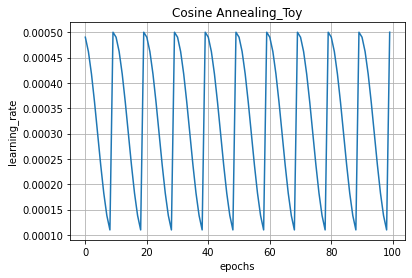

Epoch 1/100

Epoch 00001: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.00049999997, shape=(), dtype=float32).
147/147 [==============================] - 154s 796ms/step - loss: 4.8193 - accuracy: 0.0239 - top-5-accuracy: 0.1103 - val_loss: 6.9955 - val_accuracy: 0.0059 - val_top-5-accuracy: 0.0314

Epoch 00001: val_loss improved from inf to 6.99548, saving model to ./model/EfficientNetB3_aug_01-6.9955_fold:5.hdf5
Epoch 2/100

Epoch 00002: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.0004902113, shape=(), dtype=float32).
147/147 [==============================] - 114s 773ms/step - loss: 3.6634 - accuracy: 0.1092 - top-5-accuracy: 0.3598 - val_loss: 7.1274 - val_accuracy: 0.0059 - val_top-5-accuracy: 0.0297

Epoch 00002: val_loss did not improve from 6.99548
Epoch 3/100

Epoch 00003: CosineAnnealingScheduler setting learning rate to tf.Tensor(0.00046180337, shape=(), dtype=float32).
147/147 [==============================] - 114s 773ms/step - loss: 2.257

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetB0


# kfold = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

fold_no = 1
for train, val in skf.split(X, np.argmax(y, axis=1)):

    if fold_no > 4:
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        modelpath = "./model/EfficientNetB3_aug_{epoch:02d}-{val_loss:.4f}_fold:%d.hdf5" % fold_no
        checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, 
                                                        save_best_only=True)
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7)

        train_x = X[train]
        train_y = y[train]
        valid_x = X[val]
        valid_y = y[val]

        # cosine_scheduler = CosineAnnealingScheduler(num_epochs, max_rate, min_rate, cycle)
        # optimizer = AdaBelief

        optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )

        cosine_scheduler = CosineAnnealingScheduler(num_epochs, max_rate, min_rate, cycle)

        for i in range(1, num_epochs + 1):
            cosine_scheduler.plot(i)

        plt.plot(cosine_scheduler.lrates)
        plt.title('Cosine Annealing_Toy')
        plt.xlabel('epochs'); plt.ylabel('learning_rate')
        plt.grid()
        plt.show()

        model = EfficientNet_model()

        training_generator = datagen.flow(train_x, train_y, batch_size=batch_size, seed=77, shuffle=True)
        validation_generator = valgen.flow(valid_x, valid_y, batch_size=batch_size, seed=77, shuffle=True)
        history = model.fit(
            training_generator,
            shuffle=True,
            steps_per_epoch =len(train_x)//batch_size,
            epochs=num_epochs,
            validation_data=validation_generator,
            callbacks=[checkpointer, early_stopping_callback,cosine_scheduler]
        )

        del train_x
        del train_y
        del valid_x
        del valid_y

        gc.collect()
        k.clear_session()

    fold_no += 1


In [35]:
model_name1 = 'EfficientNetB3_aug_19-0.0354_fold:1.hdf5'
model1 = load_model('./model/%s' % model_name1)
model_name2 = 'EfficientNetB3_aug_19-0.0356_fold:2.hdf5'
model2 = load_model('./model/%s' % model_name2)
model_name3 = 'EfficientNetB3_aug_20-0.0744_fold:3.hdf5'
model3 = load_model('./model/%s' % model_name3)
model_name4 = 'EfficientNetB3_aug_19-0.0458_fold:4.hdf5'
model4 = load_model('./model/%s' % model_name4)
model_name5 = 'EfficientNetB3_aug_16-0.0591_fold:5.hdf5'
model5 = load_model('./model/%s' % model_name5)

In [36]:
from tensorflow.keras.preprocessing import image
test_images  = []
for test_folder in tqdm(crop_test_folders) :
    image_paths = sorted(glob(test_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
    query_path  = test_folder.replace(data_path,'')
    test_image = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(300,300,3))
        img = image.img_to_array(img)
        img = img/255
        test_image.append(img)
    test_images.append(test_image)

test_images = np.array(test_images)
print(test_images.shape)

100%|██████████| 217/217 [15:20<00:00,  4.24s/it]

(217,)


In [37]:
np.save('./crop_test_images_300', np.array(test_images))

In [38]:
test_images = np.load('./crop_test_images_300.npy',allow_pickle=True)
print(test_images.shape)

(217,)


In [39]:
print(np.array(test_images.shape))

[217]


In [40]:
np.array(test_images[0]).shape

(7, 300, 300, 3)

In [41]:
all_model = [model1, model2, model3, model4, model5]

In [42]:
sub=np.zeros((test_images.shape[0], num_classes))  

for model in all_model:
    predictions = []
    for test_image in tqdm(test_images, total = len(test_images)) : 
        prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
        predictions.append(prediction)

    sub+=predictions

mean_sub = sub/len(all_model)
mean_sub

100%|██████████| 217/217 [00:23<00:00,  9.15it/s]


array([[5.58396548e-01, 7.53661068e-03, 7.48959957e-06, ...,
        1.96423780e-05, 1.13627454e-06, 3.13915205e-05],
       [1.26452236e-03, 1.18248063e-05, 1.10383709e-06, ...,
        5.09101964e-07, 3.43656235e-08, 4.27386827e-07],
       [4.86421587e-06, 1.11259977e-03, 2.62631923e-04, ...,
        1.61353830e-06, 2.49803875e-05, 8.66625233e-07],
       ...,
       [2.18941572e-08, 7.37853229e-06, 5.00171103e-05, ...,
        2.29619377e-02, 9.24851239e-01, 4.30997792e-05],
       [8.59970499e-09, 5.50642382e-06, 3.06035227e-04, ...,
        6.92444496e-04, 6.99346718e-01, 4.13818075e-06],
       [1.54426635e-07, 2.97066925e-07, 5.61564731e-07, ...,
        9.44708820e-04, 2.44573393e-04, 9.91129017e-01]])

In [43]:
predictions_label = []
for i in mean_sub:

    predictions_label.append(np.argmax(i))

In [44]:
sample_submission.iloc[:,1:] = mean_sub
display(sample_submission.head())
sample_submission.to_csv('./submit/vti_kfold5_%s.csv' % model_name1, index=False)

,Image_Path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7,Label_8,Label_9,Label_10,Label_11,Label_12,Label_13,Label_14,Label_15,Label_16,Label_17,Label_18,Label_19,Label_22,Label_23,Label_25,Label_26,Label_27,Label_28,Label_29,Label_31,Label_32,Label_34,Label_35,Label_36,Label_37,Label_39,Label_40,Label_41,Label_42,Label_43,Label_44,...,Label_142,Label_143,Label_144,Label_145,Label_146,Label_147,Label_148,Label_149,Label_150,Label_151,Label_153,Label_154,Label_155,Label_156,Label_157,Label_158,Label_159,Label_160,Label_161,Label_162,Label_163,Label_165,Label_167,Label_168,Label_169,Label_171,Label_172,Label_173,Label_174,Label_175,Label_177,Label_186,Label_188,Label_189,Label_190,Label_191,Label_192,Label_193,Label_194,Label_195
0,./test\649,5.583965e-01,0.007537,0.000007,3.041897e-06,1.535650e-06,7.673870e-04,1.932923e-02,0.000133,3.740121e-07,3.065699e-06,0.095676,0.002425,0.000081,0.000042,1.374505e-06,0.000060,4.199107e-04,0.000020,4.212029e-06,0.000012,6.337697e-05,0.040759,3.761549e-03,1.560493e-04,0.011576,0.032144,4.250122e-04,4.591689e-06,0.002061,0.000019,0.009181,1.039232e-04,2.410522e-03,5.105299e-05,0.000018,2.981168e-05,4.418791e-04,3.437260e-06,7.870596e-04,...,1.601319e-01,9.034566e-06,2.348539e-05,1.992084e-04,1.802333e-06,1.282530e-06,0.000007,1.480916e-04,0.000007,5.273233e-06,0.000027,7.607128e-05,1.268833e-05,3.510895e-06,5.921866e-04,1.346841e-04,3.050838e-04,0.000011,0.000009,8.820564e-06,0.000037,0.000119,0.000243,7.875436e-07,1.060437e-06,3.430017e-05,4.178792e-06,0.000054,1.510272e-04,0.000029,7.744444e-07,5.703597e-06,0.000053,5.168540e-06,3.693314e-05,7.074513e-05,1.176679e-04,1.964238e-05,1.136275e-06,3.139152e-05
1,./test\650,1.264522e-03,0.000012,0.000001,7.883660e-07,4.714712e-08,4.677402e-06,1.025689e-04,0.000003,1.016595e-07,5.116313e-07,0.914348,0.002123,0.000005,0.000002,1.014263e-07,0.000038,2.065785e-03,0.000004,2.940351e-08,0.000001,6.111198e-07,0.000070,4.197895e-06,3.098679e-07,0.000002,0.000016,8.080633e-06,2.758847e-07,0.000077,0.000007,0.000009,1.676659e-07,3.691102e-07,3.014486e-07,0.000484,4.256650e-08,3.248247e-03,8.628016e-08,1.136836e-06,...,2.161398e-04,4.740131e-07,7.041408e-07,8.580941e-07,2.288945e-06,1.696438e-07,0.000008,2.475726e-05,0.000002,5.905722e-06,0.000070,4.118674e-06,1.296626e-07,7.513167e-08,6.346350e-05,1.050652e-06,4.219271e-06,0.000037,0.000019,3.733173e-06,0.000003,0.000001,0.067190,1.225282e-07,5.866186e-06,3.436435e-07,3.232141e-07,0.000002,2.584625e-05,0.000003,3.135634e-07,1.098034e-07,0.000055,1.655959e-08,6.246575e-07,1.722292e-07,9.179014e-06,5.091020e-07,3.436562e-08,4.273868e-07
2,./test\651,4.864216e-06,0.001113,0.000263,1.045879e-05,1.213223e-07,1.192487e-06,9.142589e-07,0.000061,6.457251e-06,1.227371e-06,0.001074,0.898081,0.008979,0.000107,7.974947e-07,0.000015,2.494007e-05,0.003316,9.056483e-07,0.000016,1.039133e-06,0.000005,9.051842e-07,4.636436e-07,0.000010,0.000007,1.034000e-06,6.491634e-07,0.000038,0.000015,0.000003,1.945796e-07,1.639805e-06,7.829822e-07,0.067469,1.261557e-07,1.160576e-05,6.051640e-08,1.177923e-07,...,1.482660e-06,2.251329e-07,1.841293e-08,4.319843e-07,1.027576e-06,3.074692e-07,0.000011,1.717116e-06,0.000012,5.196491e-07,0.000047,1.369324e-06,9.425262e-07,3.276400e-07,9.394131e-06,5.964519e-07,7.360592e-07,0.000004,0.000036,3.067178e-06,0.000003,0.000128,0.002116,6.937739e-07,3.600827e-07,4.307604e-07,2.715888e-07,0.000203,2.420209e-05,0.000052,3.710432e-06,6.158391e-07,0.000086,3.770810e-08,7.776233e-07,6.671503e-08,1.466889e-06,1.613538e-06,2.498039e-05,8.666252e-07
3,./test\652,4.066857e-06,0.001452,0.000721,4.453137e-06,5.633911e-08,9.392399e-07,4.678809e-07,0.000065,7.095338e-06,8.325646e-07,0.000999,0.938744,0.006661,0.000038,3.919968e-07,0.000006,1.089077e-05,0.001880,3.412367e-07,0.000008,9.557595e-07,0.000004,3.564017e-07,2.374791e-07,0.000006,0.000004,5.593317e-07,2.603989e-07,0.000051,0.000012,0.000003,1.341090e-07,2.355038e-06,3.188883e-07,0.043613,4.766824e-08,3.469557e-06,2.136441e-08,1.019127

In [45]:
predictions_label

[0,
 10,
 11,
 11,
 12,
 13,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 1,
 1,
 20,
 21,
 21,
 22,
 37,
 24,
 25,
 25,
 26,
 2,
 2,
 27,
 27,
 28,
 29,
 30,
 30,
 31,
 32,
 32,
 33,
 33,
 3,
 3,
 34,
 35,
 36,
 36,
 37,
 37,
 38,
 38,
 20,
 40,
 41,
 4,
 42,
 43,
 44,
 44,
 45,
 46,
 47,
 47,
 48,
 48,
 49,
 50,
 50,
 5,
 51,
 51,
 52,
 53,
 54,
 54,
 1,
 56,
 56,
 57,
 14,
 59,
 59,
 6,
 6,
 60,
 61,
 62,
 67,
 64,
 65,
 66,
 67,
 7,
 7,
 68,
 69,
 70,
 71,
 72,
 71,
 74,
 75,
 8,
 8,
 76,
 77,
 78,
 79,
 79,
 80,
 80,
 69,
 82,
 82,
 9,
 117,
 84,
 85,
 86,
 87,
 102,
 139,
 90,
 96,
 91,
 91,
 92,
 92,
 93,
 94,
 94,
 95,
 95,
 96,
 96,
 97,
 98,
 98,
 99,
 100,
 100,
 101,
 101,
 102,
 102,
 103,
 104,
 104,
 105,
 106,
 108,
 108,
 108,
 109,
 109,
 110,
 111,
 112,
 112,
 113,
 113,
 109,
 114,
 114,
 115,
 115,
 116,
 117,
 118,
 119,
 137,
 137,
 137,
 122,
 123,
 124,
 125,
 125,
 126,
 126,
 127,
 127,
 128,
 128,
 129,
 130,
 130,
 131,
 131,
 132,
 133,
 133,
 134,
 135,
 135,
 13

In [46]:
len(predictions_label)

217

In [57]:
for i in range(test_images.shape[0]):
    image = test_images[i][0] * 255

    plt.imshow(image.astype("uint8"))
    plt.axis("off")
    plt.show()
    
    print(f"answer_num: {np.argmax(classes[predictions_label[i]])}")
    try:
        print(list(answers['answer_name'][answers['answer']==(np.argmax(classes[predictions_label[i]]))])[0])
    except:
        print('없음')
        pass



Output hidden; open in https://colab.research.google.com to view.